# Hospital Readmissions

In [49]:
import zipfile
import os
import pandas as pd
import numpy as np

# Step 1: Extract the zip file
with zipfile.ZipFile('MIMIC-III.zip', 'r') as zip_ref:
    zip_ref.extractall('mimic_data')

# Step 2: Define the subdirectory path and load CSV files
subdirectory_path = 'mimic_data/mimic-iii-clinical-database-demo-1.4'

# Load the key datasets
admissions_df = pd.read_csv(os.path.join(subdirectory_path, 'ADMISSIONS.csv'))
patients_df = pd.read_csv(os.path.join(subdirectory_path, 'PATIENTS.csv'))

# Convert date columns to datetime
patients_df['dob'] = pd.to_datetime(patients_df['dob'], errors='coerce')
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'], errors='coerce')
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'], errors='coerce')

# Step 3: Merge admissions and patients data
merged_df = admissions_df.merge(patients_df[['subject_id', 'dob', 'gender']], on='subject_id', how='left')

# Step 4: Filter out invalid date rows and calculate age
# Remove rows with NaT in 'admittime' or 'dob' and where admittime is before dob
merged_df = merged_df[(merged_df['admittime'].notna()) & (merged_df['dob'].notna())]
merged_df = merged_df[merged_df['admittime'] > merged_df['dob']]

# Step 5: Safely calculate age using .apply() to avoid overflow issues
def calculate_age(row):
    try:
        delta = row['admittime'] - row['dob']
        age = delta.days / 365.25
        # Set age as NaN for implausible values (>120 years or negative)
        if age < 0 or age > 120:
            return np.nan
        return age
    except:
        return np.nan

merged_df['age'] = merged_df.apply(calculate_age, axis=1)

# Drop rows with missing or implausible ages
merged_df = merged_df[merged_df['age'].notna()]

# Print first few rows to verify age calculation
print("\n--- Calculated Patient Age (first 5 rows) ---")
print(merged_df[['subject_id', 'admittime', 'dob', 'age']].head())

# Step 6: Calculate length of stay, ensuring dates are valid
merged_df = merged_df[merged_df['dischtime'].notna()]
merged_df['length_of_stay'] = (merged_df['dischtime'] - merged_df['admittime']).dt.days

# Print first few rows to verify length of stay calculation
print("\n--- Length of Stay Calculation (first 5 rows) ---")
print(merged_df[['subject_id', 'admittime', 'dischtime', 'length_of_stay']].head())

# Step 7: Determine readmission within 30 days
merged_df = merged_df.sort_values(['subject_id', 'admittime'])

# Calculate time to next admission for each patient
merged_df['next_admittime'] = merged_df.groupby('subject_id')['admittime'].shift(-1)
merged_df['days_to_next_admit'] = (merged_df['next_admittime'] - merged_df['dischtime']).dt.days

# Create a flag to indicate if the patient was readmitted within 30 days
merged_df['readmitted_within_30_days'] = merged_df['days_to_next_admit'] <= 30

# Print first few rows to verify readmission calculation
print("\n--- Readmission Flag (first 5 rows) ---")
print(merged_df[['subject_id', 'admittime', 'dischtime', 'next_admittime', 'days_to_next_admit', 'readmitted_within_30_days']].head())



--- Calculated Patient Age (first 5 rows) ---
   subject_id           admittime        dob        age
0       10006 2164-10-23 21:09:00 2094-03-05  70.633812
1       10011 2126-08-14 22:32:00 2090-06-05  36.188912
2       10013 2125-10-04 23:36:00 2038-09-03  87.082820
3       10017 2149-05-26 17:19:00 2075-09-21  73.675565
4       10019 2163-05-14 20:43:00 2114-06-20  48.898015

--- Length of Stay Calculation (first 5 rows) ---
   subject_id           admittime           dischtime  length_of_stay
0       10006 2164-10-23 21:09:00 2164-11-01 17:15:00               8
1       10011 2126-08-14 22:32:00 2126-08-28 18:59:00              13
2       10013 2125-10-04 23:36:00 2125-10-07 15:13:00               2
3       10017 2149-05-26 17:19:00 2149-06-03 18:42:00               8
4       10019 2163-05-14 20:43:00 2163-05-15 12:00:00               0

--- Readmission Flag (first 5 rows) ---
   subject_id           admittime           dischtime next_admittime  \
0       10006 2164-10-23 21:09:00

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better visual appeal
sns.set(style="whitegrid")

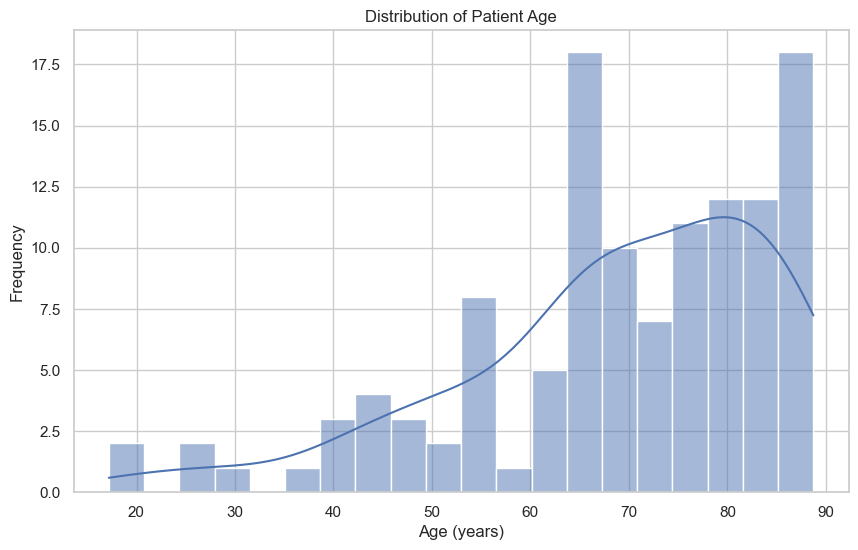

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

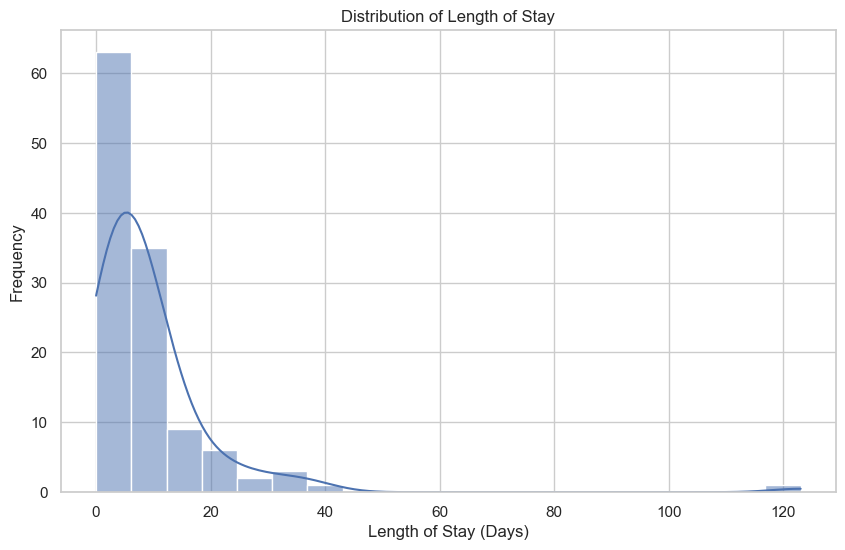

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['length_of_stay'], bins=20, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Frequency')
plt.show()

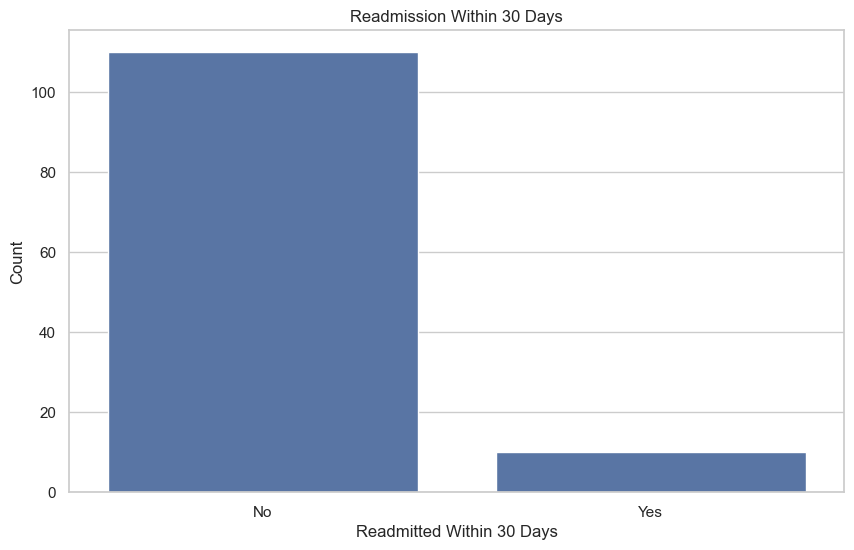

Readmission Rate within 30 Days: 8.33%


In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(x='readmitted_within_30_days', data=merged_df)
plt.title('Readmission Within 30 Days')
plt.xlabel('Readmitted Within 30 Days')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Print readmission rate
readmission_rate = merged_df['readmitted_within_30_days'].mean() * 100
print(f"Readmission Rate within 30 Days: {readmission_rate:.2f}%")

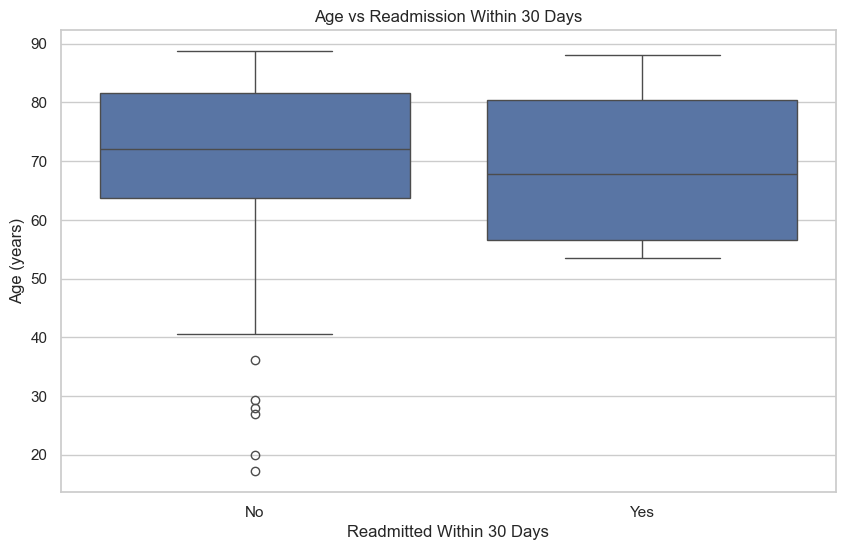

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted_within_30_days', y='age', data=merged_df)
plt.title('Age vs Readmission Within 30 Days')
plt.xlabel('Readmitted Within 30 Days')
plt.ylabel('Age (years)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

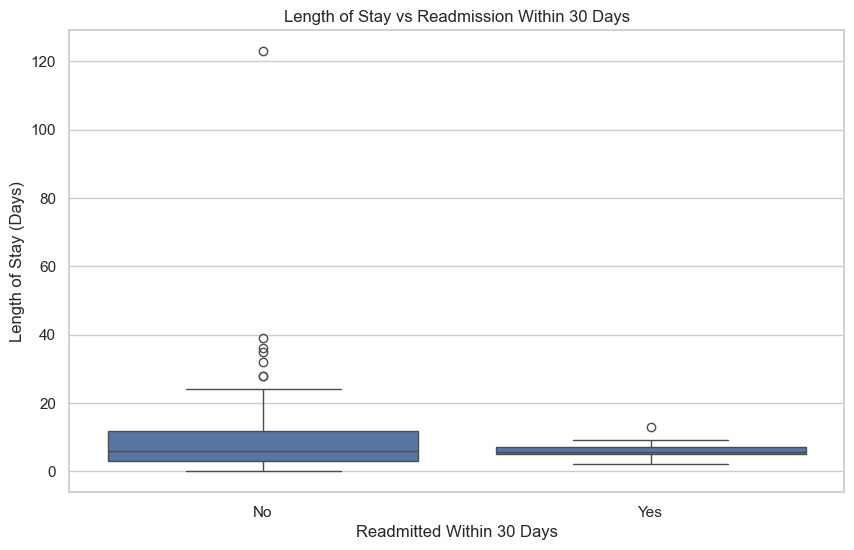

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted_within_30_days', y='length_of_stay', data=merged_df)
plt.title('Length of Stay vs Readmission Within 30 Days')
plt.xlabel('Readmitted Within 30 Days')
plt.ylabel('Length of Stay (Days)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

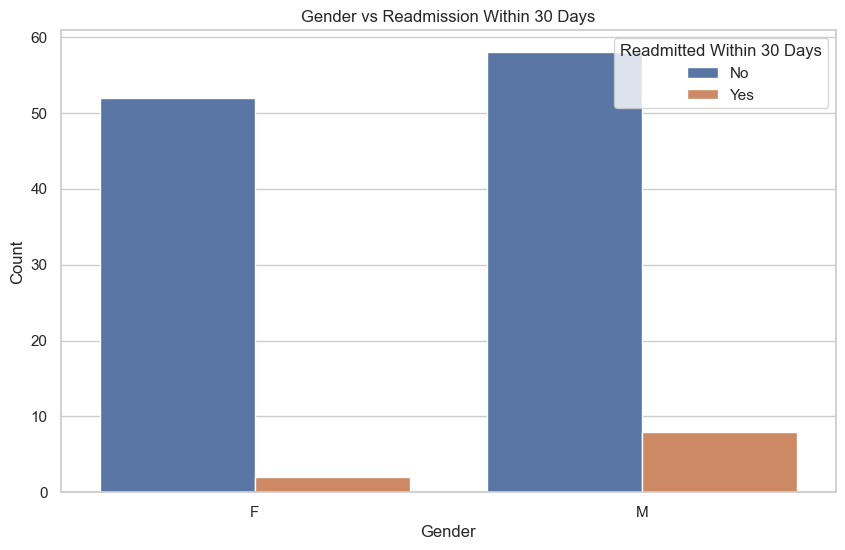

In [63]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='readmitted_within_30_days', data=merged_df)
plt.title('Gender vs Readmission Within 30 Days')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Readmitted Within 30 Days', labels=['No', 'Yes'])
plt.show()


--- Most Common ICD-9 Diagnoses for Readmitted Patients ---
icd9_code
4019     8
5990     4
42731    4
2724     4
5849     4
V5861    3
25000    3
2449     3
4439     3
4280     3
Name: count, dtype: int64


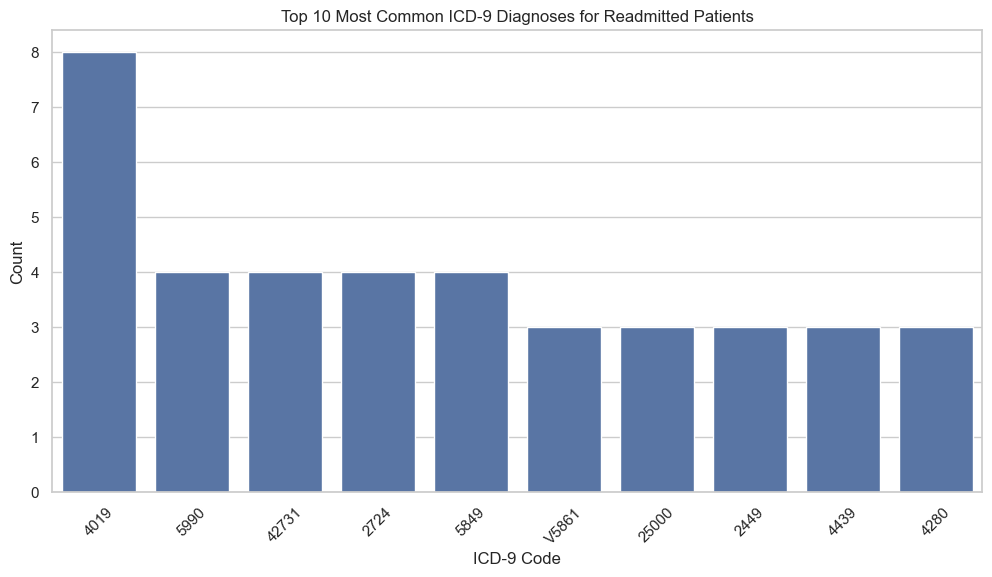

In [65]:
# Common Diagnoses Analysis for Readmitted Patients

# Filter only readmitted patients
readmitted_patients = merged_df[merged_df['readmitted_within_30_days'] == True]

# Merge with diagnoses dataset to get ICD-9 codes for readmitted patients
readmitted_diagnoses = readmitted_patients.merge(diagnoses_df[['hadm_id', 'icd9_code']], on='hadm_id', how='left')

# Count the most common ICD-9 codes among readmitted patients
common_icd9 = readmitted_diagnoses['icd9_code'].value_counts().head(10)

# Print the most common diagnoses for readmitted patients
print("\n--- Most Common ICD-9 Diagnoses for Readmitted Patients ---")
print(common_icd9)

# Plot the most common ICD-9 diagnoses for readmitted patients
plt.figure(figsize=(12, 6))
sns.barplot(x=common_icd9.index, y=common_icd9.values)
plt.title('Top 10 Most Common ICD-9 Diagnoses for Readmitted Patients')
plt.xlabel('ICD-9 Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Patient Demographics:
# Age Distribution: See how the ages of patients are distributed.
# Gender Distribution: Visualize the impact of gender on readmission.

# Readmission Analysis:
# The proportion of readmissions within 30 days provides insights into how often readmissions happen.
# Age and Readmission: Explore whether age is a factor in the likelihood of being readmitted.
# Length of Stay and Readmission: Understand whether a longer or shorter stay impacts readmission likelihood.

# Diagnoses Analysis:
# The most common diagnoses associated with readmitted patients will help you identify risk areas that may need intervention.